In [1]:
import numpy as np
import pandas as pd
import re
import contractions
import bs4
from nltk.corpus import stopwords
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use("default")
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data.csv")

# Preprocessing

The following preprocessing tasks are performed on the data set:

* Drop NULL values
* Drop duplicate rows
* Expand contractions
* Remove HTML tags
* Remove non alphabet characters
* Remove extra whitespaces
* Remove stop words
* Remove short words

In [3]:
df = df[['Content', 'Summary', 'Dataset']]

In [4]:
df = df.dropna().reset_index(drop=True)

In [5]:
df = df.drop_duplicates(subset=['Content', 'Summary']).reset_index(drop=True)

In [6]:
soup = bs4.BeautifulSoup

In [7]:
stop_words = stopwords.words("english")

In [8]:
def text_preprocess(text_list):
    
    # Expand contractions
    text_list = [contractions.fix(sentence) for sentence in text_list]
    # Remove HTML tags
    text_list = [soup(sentence, "html.parser").get_text() for sentence in text_list]
    # Keep only alphabet characters and whitespaces
    text_list = [re.sub(r"[^a-zA-Z\s]", " ", sentence).lower() for sentence in text_list]
    # Remove \n
    text_list = [re.sub(r"\n", "", sentence) for sentence in text_list]
    # Remove extra whitespaces
    text_list = [re.sub(" +", " ", sentence) for sentence in text_list]
    # Remove stop words and short words
    text_list = [[word for word in sentence.split() if not word in stop_words and len(word)>=3] 
                 for sentence in text_list]
    text_list = [" ".join(sentence) for sentence in text_list]
    
    return text_list

In [9]:
st = time.time()

cont = text_preprocess(df['Content'])

et = time.time()
print("Time taken: {:d} h {:d} min {:.2f} s".format(int((et - st)/3600), int(((et - st)%3600)/60), ((et - st)%3600)%60))

Time taken: 0 h 15 min 46.13 s


In [10]:
st = time.time()

summ = text_preprocess(df['Summary'])

et = time.time()
print("Time taken: {:d} h {:d} min {:.2f} s".format(int((et - st)/3600), int(((et - st)%3600)/60), ((et - st)%3600)%60))

Time taken: 0 h 1 min 25.45 s


In [11]:
df_clean = pd.DataFrame({'Content':cont, 'Summary':summ})

In [12]:
# Sentence lengths of Content and Summary
len_c = np.array([len(x.split()) for x in df_clean['Content']])
len_s = np.array([len(x.split()) for x in df_clean['Summary']])

Rows which satifsy any one of the following conditions are removed:

* Length of the Content sentence is less than that of the Summary sentence
* Length of the Content sentence is less than or equal to 15
* Length of the Content sentence is greater than or equal to 2500
* Length of the Summary sentence is less than or equal to 10
* Length of the Summary sentence is greater than or equal to 15

In [13]:
flag_1 = len_c > len_s
flag_2 = len_c > 15
flag_3 = len_c < 2500
flag_4 = len_s > 10
flag_5 = len_s < 250

df_clean = df_clean.iloc[np.where(flag_1 & flag_2 & flag_3 & flag_4 & flag_5)[0]]
df_clean.reset_index(inplace=True, drop=True)

In [14]:
# START and END tokens are added to the Summary sentences for the decoder
df_clean['Summary_clean'] = ["<START> " + sentence + " <END>" for sentence in df_clean['Summary']]

In [15]:
len_c = np.array([len(x.split()) for x in df_clean['Content']])
len_s = np.array([len(x.split()) for x in df_clean['Summary']])

In [16]:
df_clean.to_csv("data_clean.csv", index=False)

# EDA

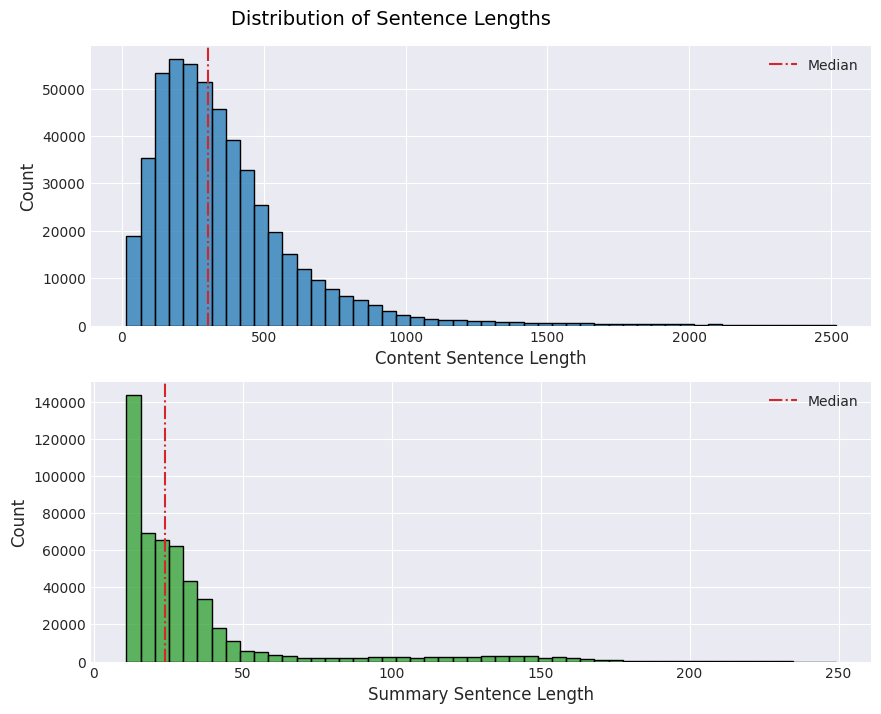

In [41]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), dpi=100)
    sns.histplot(data=len_c, ax=ax[0], binwidth=50, color='tab:blue');
    sns.histplot(data=len_s, ax=ax[1], bins=50, color='tab:green');
    
    ax[0].set_ylabel("Count", fontsize=12)
    ax[1].set_ylabel("Count", fontsize=12)
    ax[0].set_xlabel("Content Sentence Length", fontsize=12)
    ax[1].set_xlabel("Summary Sentence Length", fontsize=12)
    
    ax[0].axvline(np.median(len_c), linestyle="-.", color='tab:red', label='Median')
    ax[1].axvline(np.median(len_s), linestyle="-.", color='tab:red', label='Median')
    
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    
plt.suptitle("Distribution of Sentence Lengths", fontsize=14, y=0.925);
plt.subplots_adjust(0.25);

In [22]:
print("Content:")
print("\tMean Length: {:.2f}".format(np.mean(len_c)))
print("\tMedian Length: {:.2f}".format(np.median(len_c)))
print("\nSummary:")
print("\tMean Length: {:.2f}".format(np.mean(len_s)))
print("\tMedian Length: {:.2f}".format(np.median(len_s)))

Content:
	Mean Length: 368.12
	Median Length: 303.00

Summary:
	Mean Length: 34.01
	Median Length: 24.00
